# Explicability with SHAP values

In [5]:
import shap
import joblib
import pandas as pd
import re
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig, close

We will be using LinearExplainer


Computes SHAP values for a linear model, optionally accounting for inter-feature correlations.

This computes the SHAP values for a linear model and can account for the correlations among the input features. Assuming features are independent leads to interventional SHAP values which for a linear model are coef[i] * (x[i] - X.mean(0)[i]) for the ith feature. If instead we account for correlations then we prevent any problems arising from colinearity and share credit among correlated features. Accounting for correlations can be computationally challenging, but LinearExplainer uses sampling to estimate a transform that can then be applied to explain any prediction of the mode

In [43]:
# Function to convert probes names
def convert_probe_names(labels, probe_info): 
    """Convert probe text to also contain the associated gene/genes"""
    # Create a new column 'genes_clean' by splitting 'UCSC_RefGene_Name' and collapsing unique values
    probe_info['genes_clean'] = probe_info['UCSC_RefGene_Name'].apply(lambda x: ';'.join(sorted(set(str(x).split(';')))) if pd.notnull(x) else '')
    # Create a new column 'feature_full_name' by concatenating 'IlmnID' and 'genes_clean'
    probe_info['feature_full_name'] = probe_info['IlmnID'] + probe_info['genes_clean'].apply(lambda x: ' - ' + x if x != "" else "")
    probe_info = probe_info.set_index("IlmnID")

    for i in range(len(labels)): 
        labels[i] = probe_info.loc[labels[i], "feature_full_name"]
    
    return labels

def convert_beta_to_m(meth):
    """Convert beta values to M values"""
    beta_columns = meth.columns
    m_columns = []

    for beta_column in beta_columns:
        if beta_column == "probe": 
            m_columns.append(meth["probe"])
        else: 
            m_columns.append(np.log2(meth[beta_column] / (1 - meth[beta_column])))

    m_dataframe = pd.concat(m_columns, axis=1)

    return m_dataframe

def normalize_score(shap_values_df): 
    """Normalize the score"""
    mean_abs_scores = shap_values_df.abs().mean()

    normalized_scores = (mean_abs_scores / mean_abs_scores.sum()) * 100

    normalized_scores_df = pd.DataFrame({
        'column_name': mean_abs_scores.index,
        'score': mean_abs_scores.values,
        'normalized_score': normalized_scores.values
    })
    return normalized_scores_df[normalized_scores_df.score != 0]




In [7]:
## Load probes annotation
probe_info = pd.read_csv("../../metadata/methylation_epic_v1.0b5.csv")

Columns (2,4,42,47) have mixed types. Specify dtype option on import or set low_memory=False.


In [37]:
# Load models
lung = joblib.load("../../results/4.methylation_models/lung/5.pipeline.pkl")
colon = joblib.load("../../results/4.methylation_models/colon_transverse/5.pipeline.pkl")
ovary = joblib.load("../../results/4.methylation_models/ovary/5.pipeline.pkl")
prostate = joblib.load("../../results/4.methylation_models/prostate/5.pipeline.pkl")


In [58]:
def compute_shap_values(pipeline, tissue):
    """Compute SHap values using linearExplainer"""
    if tissue == "colon": 
        coef = pd.read_csv("../../results/4.methylation_models/colon_transverse/5.linear_models_coefs.csv")
    else: 
        coef = pd.read_csv(f"../../results/4.methylation_models/{tissue}/5.linear_models_coefs.csv")
    # Load Lung data
    meth = pd.read_csv(f"../../data/methylation_{tissue}.csv")
    test_set = pd.read_csv(f"../../metadata/{tissue}_test_metadata.csv")
    metadata = pd.read_csv(f"../../metadata/{tissue}_annotation_meth.csv")

    meth = convert_beta_to_m(meth)

    # Parse metadata and subset test set
    meth.columns = [re.sub(r"-SM-.*", "", i) for i in meth.columns.to_list()]
    metadata["sample_id"] = [re.sub(r"-SM-.*", "", i) for i in metadata.Sample_ID.to_list()]

    metadata_train = metadata.query("sample_id not in @test_set.sample_id")
    metadata_test = metadata.query("sample_id in @test_set.sample_id")

    # Filter for probes in the model
    meth.index = meth.probe
    meth = meth.reindex(coef.probe)
    meth = meth.drop("probe", axis = 1)

    # Transpose the data
    meth = meth.T

    ### Subset the test set for meth data
    meth_train = meth[meth.index.isin(metadata_train.sample_id)]
    meth_test = meth[meth.index.isin(metadata_test.sample_id)]


    # Normalize the data 
    qt_norm = pipeline[0]
    meth_train_norm = qt_norm.transform(meth_train)
    meth_test_norm = qt_norm.transform(meth_test)


    explainer = shap.LinearExplainer(model = pipeline[1], masker = shap.maskers.Independent(meth_train_norm))
    shap_values = explainer.shap_values(meth_test_norm)

    return(shap_values, pd.DataFrame(shap_values, columns=meth_train.columns.tolist()), meth_test_norm)

In [61]:
shap_values_lung, shap_values_lung_df, meth_test_norm_lung = compute_shap_values(lung, "lung")
shap_values_colon, shap_values_colon_df,  meth_test_norm_colon = compute_shap_values(colon, "colon")
shap_values_ovary, shap_values_ovary_df,  meth_test_norm_ovary = compute_shap_values(ovary, "ovary")
shap_values_prostate, shap_values_prostate_df,  meth_test_norm_prostate = compute_shap_values(prostate, "prostate")


In [63]:
## Convert gene names 
feature_names_lung = convert_probe_names(shap_values_lung_df.columns.tolist(), probe_info)
feature_names_colon = convert_probe_names(shap_values_colon_df.columns.tolist(), probe_info)
feature_names_ovary = convert_probe_names(shap_values_ovary_df.columns.tolist(), probe_info)
feature_names_prostate = convert_probe_names(shap_values_prostate_df.columns.tolist(), probe_info)

In [64]:
shap_values_lung_df_norm = normalize_score(shap_values_lung_df)
shap_values_colon_df_norm = normalize_score(shap_values_colon_df)
shap_values_ovary_df_norm = normalize_score(shap_values_ovary_df)
shap_values_prostate_df_norm = normalize_score(shap_values_prostate_df)


In [85]:
shap_values_lung_df_norm.to_csv("../../results/6.feature_importance/4_shap_values_lung.csv")
shap_values_colon_df_norm.to_csv("../../results/6.feature_importance/4_shap_values_colon.csv")
shap_values_ovary_df_norm.to_csv("../../results/6.feature_importance/4_shap_values_ovary.csv")
shap_values_prostate_df_norm.to_csv("../../results/6.feature_importance/4_shap_values_prostate.csv")


## Make plot for each tissue

SHAP value measures the impact
- Positive values: contribute to increase age
- Decrease: contribute to decrease age

### Lung

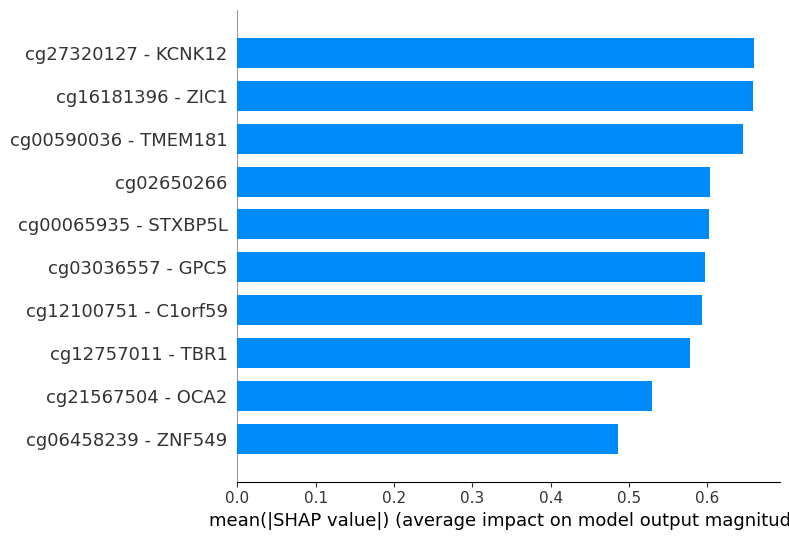

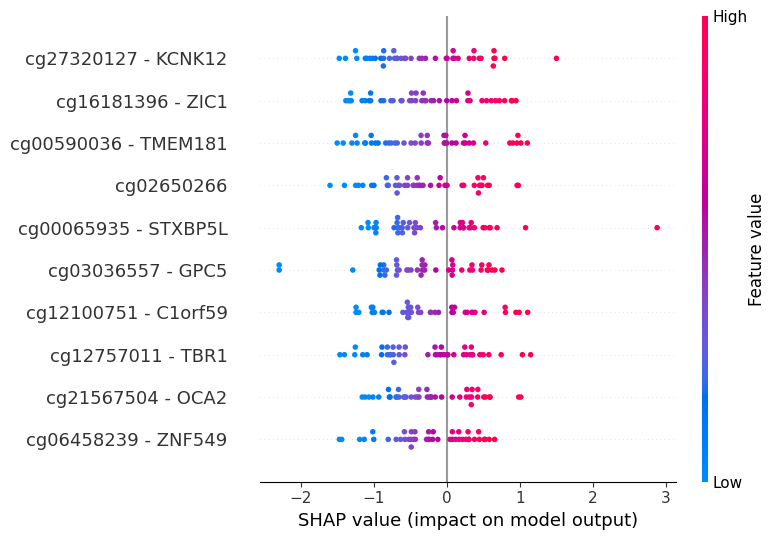

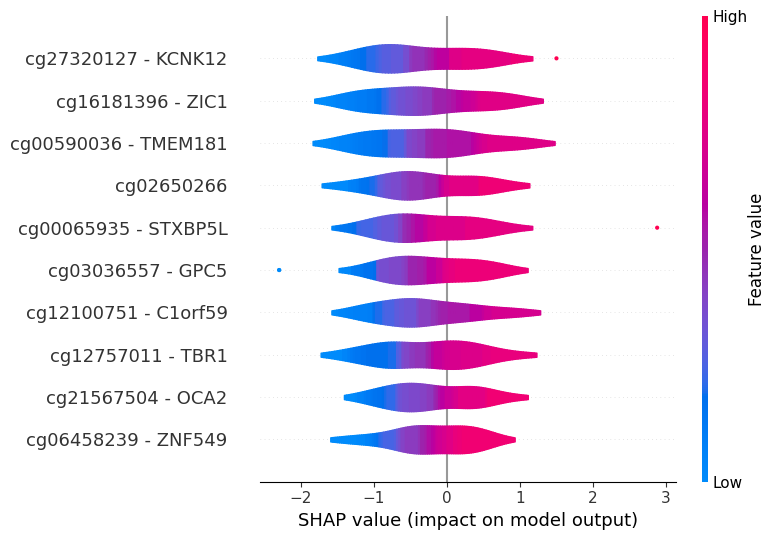

In [74]:
shap.summary_plot(
    shap_values_lung, feature_names=feature_names_lung, plot_type="bar", max_display = 10
)

shap.summary_plot(
    shap_values_lung, meth_test_norm_lung, feature_names=feature_names_lung, max_display = 10
)


shap.summary_plot(
    shap_values_lung, meth_test_norm_lung, feature_names=feature_names_lung, plot_type="violin", max_display = 10
)


## Save plots
shap.summary_plot(
    shap_values_lung, feature_names=feature_names_lung, plot_type="bar", max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_lung_shap_feature_plot_bar.pdf")
close()

shap.summary_plot(
    shap_values_lung, meth_test_norm_lung, feature_names=feature_names_lung, max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_lung_shap_feature_plot.pdf")
close()

shap.summary_plot(
    shap_values_lung, meth_test_norm_lung, feature_names=feature_names_lung, plot_type="violin", max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_lung_shap_feature_violin_bar.pdf")
close()


### Colon

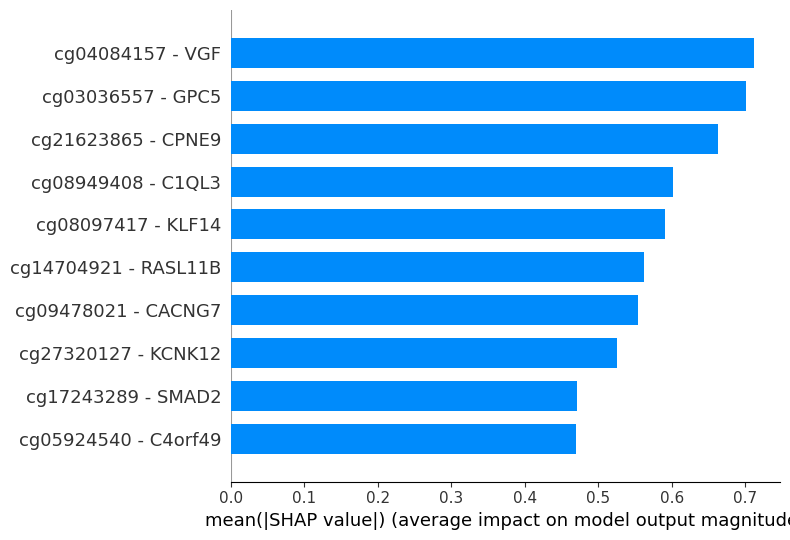

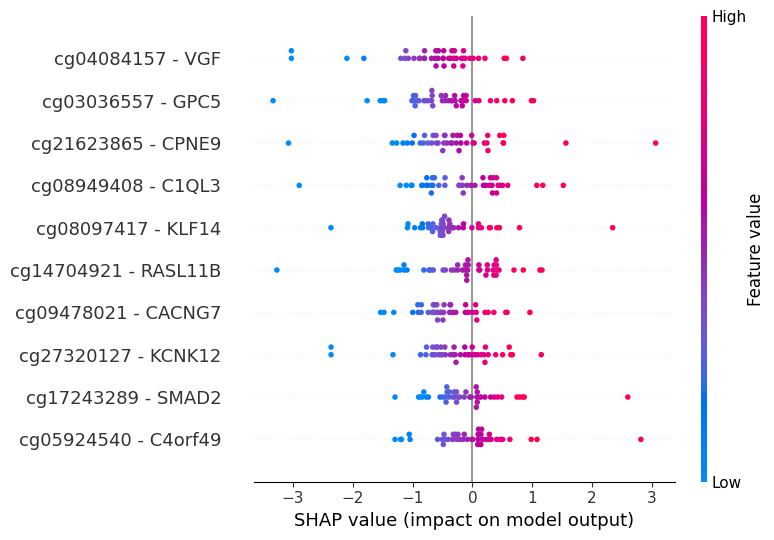

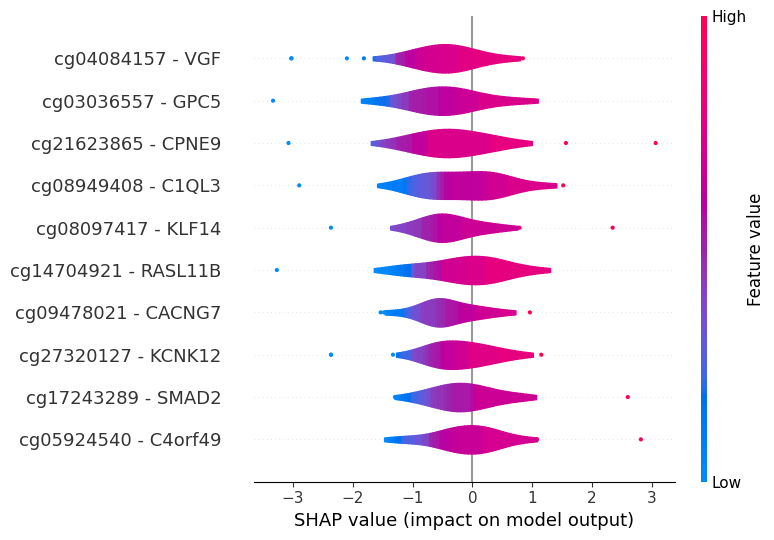

In [75]:
shap.summary_plot(
    shap_values_colon, feature_names=feature_names_colon, plot_type="bar", max_display = 10
)

shap.summary_plot(
    shap_values_colon, meth_test_norm_colon, feature_names=feature_names_colon, max_display = 10
)


shap.summary_plot(
    shap_values_colon, meth_test_norm_colon, feature_names=feature_names_colon, plot_type="violin", max_display = 10
)


## Save plots
shap.summary_plot(
    shap_values_colon, feature_names=feature_names_colon, plot_type="bar", max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_colon_shap_feature_plot_bar.pdf")
close()

shap.summary_plot(
    shap_values_colon, meth_test_norm_colon, feature_names=feature_names_colon, max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_colon_shap_feature_plot.pdf")
close()

shap.summary_plot(
    shap_values_colon, meth_test_norm_colon, feature_names=feature_names_colon, plot_type="violin", max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_colon_shap_feature_violin_bar.pdf")
close()


### Ovary

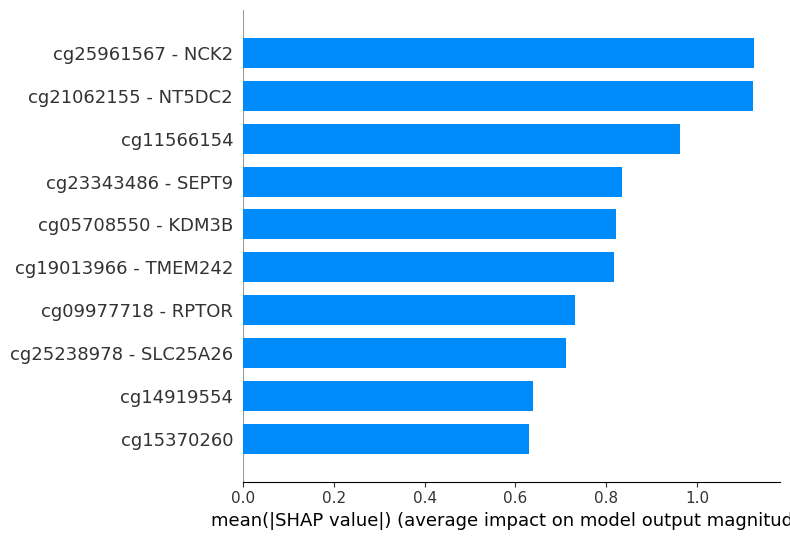

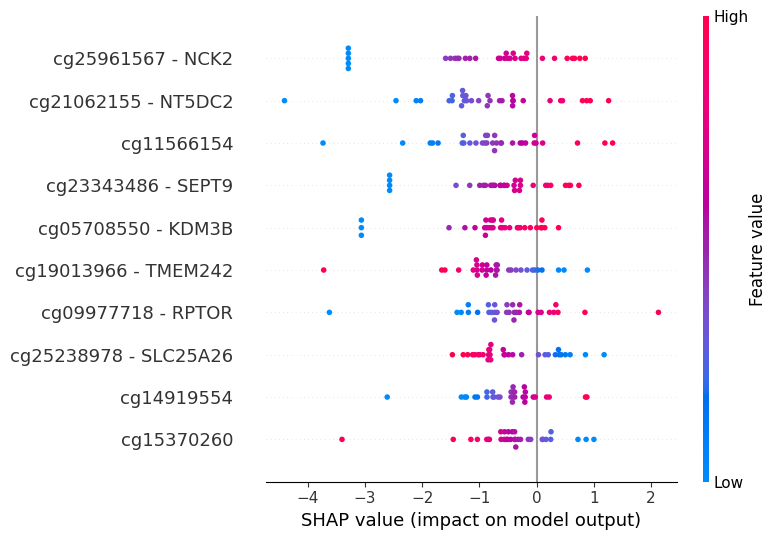

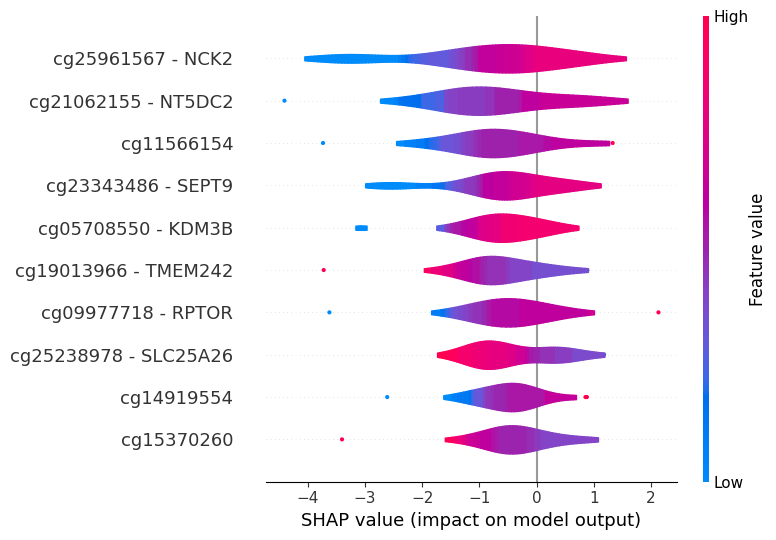

In [77]:
shap.summary_plot(
    shap_values_ovary, feature_names=feature_names_ovary, plot_type="bar", max_display = 10
)

shap.summary_plot(
    shap_values_ovary, meth_test_norm_ovary, feature_names=feature_names_ovary, max_display = 10
)


shap.summary_plot(
    shap_values_ovary, meth_test_norm_ovary, feature_names=feature_names_ovary, plot_type="violin", max_display = 10
)


## Save plots
shap.summary_plot(
    shap_values_ovary, feature_names=feature_names_ovary, plot_type="bar", max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_ovary_shap_feature_plot_bar.pdf")
close()

shap.summary_plot(
    shap_values_ovary, meth_test_norm_ovary, feature_names=feature_names_ovary, max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_ovary_shap_feature_plot.pdf")
close()

shap.summary_plot(
    shap_values_ovary, meth_test_norm_ovary, feature_names=feature_names_ovary, plot_type="violin", max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_ovary_shap_feature_violin_bar.pdf")
close()


### Prostate

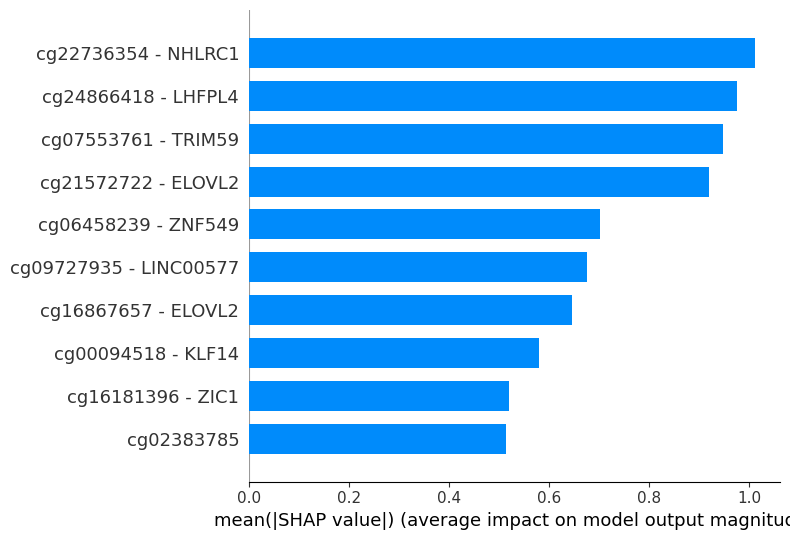

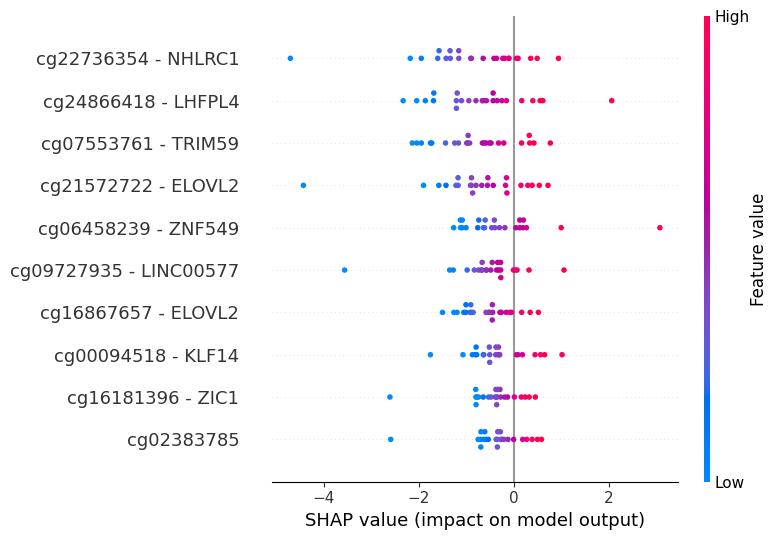

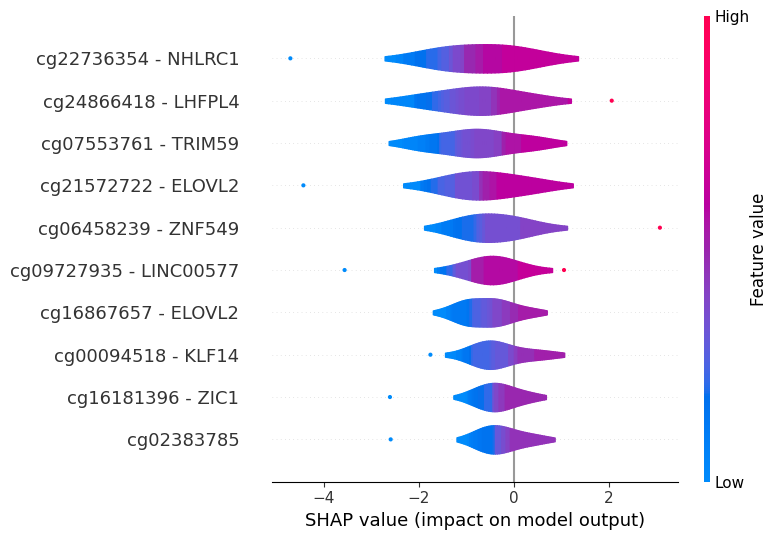

In [83]:
shap.summary_plot(
    shap_values_prostate, feature_names=feature_names_prostate, plot_type="bar", max_display = 10
)

shap.summary_plot(
    shap_values_prostate, meth_test_norm_prostate, feature_names=feature_names_prostate, max_display = 10
)


shap.summary_plot(
    shap_values_prostate, meth_test_norm_prostate, feature_names=feature_names_prostate, plot_type="violin", max_display = 10
)


## Save plots
shap.summary_plot(
    shap_values_prostate, feature_names=feature_names_prostate, plot_type="bar", max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_prostate_shap_feature_plot_bar.pdf")
close()

shap.summary_plot(
    shap_values_prostate, meth_test_norm_prostate, feature_names=feature_names_prostate, max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_prostate_shap_feature_plot.pdf")
close()

shap.summary_plot(
    shap_values_prostate, meth_test_norm_prostate, feature_names=feature_names_prostate, plot_type="violin", max_display = 10, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/6.4.5_prostate_shap_feature_violin_bar.pdf")
close()
